In [2]:
%reload_ext autoreload
%autoreload 2

from geometry import Cuboid, Rectangle
from model import Data
from boundary import DirichletBC, NeumannBC
from grad import PytorchPDE
from plot import plot_2D 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd.functional import vjp, vhp, jacobian, hessian

device = torch.device("cuda:0")

In [3]:
def boundary_t(x, on_boundary):
        return on_boundary and np.isclose(x[0], 0)   
def boundary_x(x, on_boundary):
        return on_boundary and (np.isclose(x[1], -1) or np.isclose(x[1], 1))
    
def func_t(x):
        return -1*torch.sin(np.pi*x[:,1])
def func_x(x):
        return x[:,0]*0

geom = Rectangle([0, -1],[1, 1])
bc_t = DirichletBC(geom, func_t, boundary_t)
bc_x = DirichletBC(geom, func_x, boundary_x)
data = Data(geom, [bc_t, bc_x], num_domain=10000, num_boundary=400, num_test=10000)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 50)
        self.fc5 = nn.Linear(50, 1)

    # x represents our data
    def forward(self, x):

        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.fc3(x)
        x = torch.tanh(x)
        x = self.fc4(x)
        x = torch.tanh(x)
        output = self.fc5(x)
        return output
    
my_nn = Net()
my_nn.to(device)

Net(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=50, bias=True)
  (fc5): Linear(in_features=50, out_features=1, bias=True)
)

In [5]:
def pde(x,y,first_grads,second_grads):
#     print(second_grads)
    return first_grads[:,0] + y[:,0]*first_grads[:,1] - (0.01/np.pi)*second_grads[1][:,1]

model = PytorchPDE(my_nn, data, pde, device)
model.train()

i: 1000 ; test_loss:  tensor(0.1056, device='cuda:0', grad_fn=<AddBackward0>)
i: 2000 ; test_loss:  tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)
i: 3000 ; test_loss:  tensor(0.0297, device='cuda:0', grad_fn=<AddBackward0>)
i: 4000 ; test_loss:  tensor(0.0191, device='cuda:0', grad_fn=<AddBackward0>)
i: 5000 ; test_loss:  tensor(0.0115, device='cuda:0', grad_fn=<AddBackward0>)
Finished Training


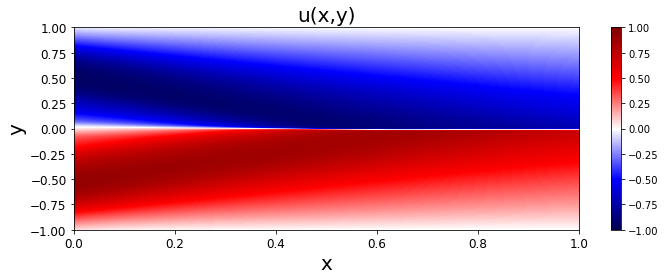

In [6]:
plot_2D(my_nn, data)

In [31]:
random_data = torch.rand((10, 2))
np.zeros((len(random_data), ))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [30]:
random_data[:,0]

tensor([0.7161, 0.2519, 0.1380, 0.5146, 0.4031, 0.3028, 0.9641, 0.1102, 0.6714,
        0.9609])

In [32]:
random_data

tensor([[0.7564, 0.2407],
        [0.6065, 0.8533],
        [0.0706, 0.7185],
        [0.3801, 0.9559],
        [0.6891, 0.2070],
        [0.0740, 0.6403],
        [0.7731, 0.4960],
        [0.1614, 0.6728],
        [0.1082, 0.6440],
        [0.5258, 0.2824]])

In [33]:
random_data - 1

tensor([[-0.2436, -0.7593],
        [-0.3935, -0.1467],
        [-0.9294, -0.2815],
        [-0.6199, -0.0441],
        [-0.3109, -0.7930],
        [-0.9260, -0.3597],
        [-0.2269, -0.5040],
        [-0.8386, -0.3272],
        [-0.8918, -0.3560],
        [-0.4742, -0.7176]])